In [2]:
import base64
import numpy as np
import pandas as pd
import pickle
import time
from pprint import pprint
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
import os
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
# tqdm
from tqdm import tqdm
init_notebook_mode(connected=True) #do not miss this line

from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



import time
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['age-related', 'macular degeneration', 'amd', 'patients', 'macular','degeneration','however','may'])

In [4]:
# Import Dataset
df = pd.read_csv('papers.csv')
df.head()

,text,label,pubmed_id
0,We demonstrated the effectiveness of transpupi...,AMD,16922162
1,The electrogenesis of the retinal macular regi...,AMD,19284097
2,To define the role of increased fundus autoflu...,AMD,25982972
3,Retinal pigment epithelium (RPE)-derived membr...,AMD,20651235
4,Although a reduced aflibercept (2.0 mg) inject...,AMD,26296050


In [5]:
# Convert to list
data = df.text.values.tolist()
pmids = df.pubmed_id.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]

pprint(data[:1])

['We demonstrated the effectiveness of transpupillary thermotherapy (TTT) for '
 'the treatment of choroidal neovascularization (CNV) by patients with age- '
 'related macular degeneration (ARMD). CNV secondary to ARMD is a leading case '
 'of vision loss in patients older than 50 years. TTT is new promising method '
 'for the treatment CNV by ARMD. It is able to close CNV while maintaining '
 'visual function and in small percentage visual function improving. We have '
 'performed TTT by 30 patients (30 eyes) with subfoveolar CNV. We have '
 'demonstrated the stabilization or improvement of visual acuity by 16 '
 'patients (52%), improvemend two or more lines was documented by 5 patients '
 '(17%). ']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'demonstrated', 'the', 'effectiveness', 'of', 'transpupillary', 'thermotherapy', 'ttt', 'for', 'the', 'treatment', 'of', 'choroidal', 'cnv', 'by', 'patients', 'with', 'age', 'related', 'macular', 'degeneration', 'armd', 'cnv', 'secondary', 'to', 'armd', 'is', 'leading', 'case', 'of', 'vision', 'loss', 'in', 'patients', 'older', 'than', 'years', 'ttt', 'is', 'new', 'promising', 'method', 'for', 'the', 'treatment', 'cnv', 'by', 'armd', 'it', 'is', 'able', 'to', 'close', 'cnv', 'while', 'maintaining', 'visual', 'function', 'and', 'in', 'small', 'percentage', 'visual', 'function', 'improving', 'we', 'have', 'performed', 'ttt', 'by', 'patients', 'eyes', 'with', 'subfoveolar', 'cnv', 'we', 'have', 'demonstrated', 'the', 'stabilization', 'or', 'improvement', 'of', 'visual', 'acuity', 'by', 'patients', 'improvemend', 'two', 'or', 'more', 'lines', 'was', 'documented', 'by', 'patients']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['we', 'demonstrated', 'the', 'effectiveness', 'of', 'transpupillary_thermotherapy_ttt', 'for', 'the', 'treatment', 'of', 'choroidal', 'cnv', 'by', 'patients', 'with', 'age', 'related', 'macular', 'degeneration', 'armd', 'cnv', 'secondary', 'to', 'armd', 'is', 'leading', 'case', 'of', 'vision', 'loss', 'in', 'patients', 'older', 'than', 'years', 'ttt', 'is', 'new', 'promising', 'method', 'for', 'the', 'treatment', 'cnv', 'by', 'armd', 'it', 'is', 'able', 'to', 'close', 'cnv', 'while', 'maintaining', 'visual', 'function', 'and', 'in', 'small', 'percentage', 'visual', 'function', 'improving', 'we', 'have', 'performed', 'ttt', 'by', 'patients', 'eyes', 'with', 'subfoveolar', 'cnv', 'we', 'have', 'demonstrated', 'the', 'stabilization', 'or', 'improvement', 'of', 'visual', 'acuity', 'by', 'patients', 'improvemend', 'two', 'or', 'more', 'lines', 'was', 'documented', 'by', 'patients']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['demonstrate', 'effectiveness', 'transpupillary_thermotherapy', 'ttt', 'treatment', 'choroidal', 'cnv', 'age', 'relate', 'armd', 'cnv', 'secondary', 'armd', 'lead', 'case', 'vision', 'loss', 'old', 'year', 'ttt', 'new', 'promising', 'method', 'treatment', 'cnv', 'armd', 'able', 'close', 'cnv', 'maintain', 'visual', 'function', 'small', 'percentage', 'visual', 'function', 'improve', 'perform', 'ttt', 'eye', 'subfoveolar', 'cnv', 'demonstrate', 'stabilization', 'improvement', 'visual', 'acuity', 'improvemend', 'line', 'document']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(dict(id2word))

{0: 'able', 1: 'acuity', 2: 'age', 3: 'armd', 4: 'case', 5: 'choroidal', 6: 'close', 7: 'cnv', 8: 'demonstrate', 9: 'document', 10: 'effectiveness', 11: 'eye', 12: 'function', 13: 'improve', 14: 'improvemend', 15: 'improvement', 16: 'lead', 17: 'line', 18: 'loss', 19: 'maintain', 20: 'method', 21: 'new', 22: 'old', 23: 'percentage', 24: 'perform', 25: 'promising', 26: 'relate', 27: 'secondary', 28: 'small', 29: 'stabilization', 30: 'subfoveolar', 31: 'transpupillary_thermotherapy', 32: 'treatment', 33: 'ttt', 34: 'vision', 35: 'visual', 36: 'year', 37: 'activity', 38: 'aged', 39: 'amplitude', 40: 'atrophy', 41: 'average', 42: 'central', 43: 'change', 44: 'coherent', 45: 'component', 46: 'confluent', 47: 'correlation', 48: 'cystic', 49: 'datum', 50: 'decrease', 51: 'detachment', 52: 'different', 53: 'druzen', 54: 'electrogenesis', 55: 'erg', 56: 'establish', 57: 'extent', 58: 'exudative', 59: 'focal', 60: 'form', 61: 'foveal', 62: 'hexagon', 63: 'latency', 64: 'mf_erg', 65: 'mferg', 66:

In [11]:
# Create Corpus
texts = data_lemmatized

In [12]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 5), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 3), (34, 1), (35, 3), (36, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('acuity', 1),
  ('age', 1),
  ('armd', 3),
  ('case', 1),
  ('choroidal', 1),
  ('close', 1),
  ('cnv', 5),
  ('demonstrate', 2),
  ('document', 1),
  ('effectiveness', 1),
  ('eye', 1),
  ('function', 2),
  ('improve', 1),
  ('improvemend', 1),
  ('improvement', 1),
  ('lead', 1),
  ('line', 1),
  ('loss', 1),
  ('maintain', 1),
  ('method', 1),
  ('new', 1),
  ('old', 1),
  ('percentage', 1),
  ('perform', 1),
  ('promising', 1),
  ('relate', 1),
  ('secondary', 1),
  ('small', 1),
  ('stabilization', 1),
  ('subfoveolar', 1),
  ('transpupillary_thermotherapy', 1),
  ('treatment', 2),
  ('ttt', 3),
  ('vision', 1),
  ('visual', 3),
  ('year', 1)]]

In [58]:
%%time
print("Training LDA model on dataframe...")

NUM_TOPICS = 80
start_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.save('models/model' + str(NUM_TOPICS) + '.gensim')
train_time = time.time() - start_time
print("Training Time --- %s seconds " % (round(train_time, 2)))

Training LDA model on dataframe...
Training Time --- 1144.53 seconds 
CPU times: user 56min 8s, sys: 2min 7s, total: 58min 15s
Wall time: 19min 4s


In [59]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(73,
  '0.103*"newly_diagnos" + 0.082*"september" + 0.072*"newly_diagnosed" + '
  '0.064*"attenuate" + 0.055*"beneficiary" + 0.046*"university_hospital" + '
  '0.045*"circulation" + 0.036*"srd" + 0.030*"nucleus" + 0.024*"pubmed"'),
 (31,
  '0.084*"intravitreous" + 0.066*"aqueous" + 0.049*"senescence" + '
  '0.046*"antagonist" + 0.032*"stabilisation" + 0.030*"bmp" + 0.025*"constant" '
  '+ 0.021*"definite" + 0.021*"cri" + 0.021*"rbp"'),
 (33,
  '0.159*"crp" + 0.058*"wamd" + 0.051*"reactive_protein" + 0.050*"iai" + '
  '0.033*"recognition" + 0.025*"context" + 0.023*"visually" + 0.020*"island" + '
  '0.018*"mg" + 0.017*"rely"'),
 (30,
  '0.073*"peptide" + 0.051*"conversion" + 0.050*"monkey" + 0.037*"compose" + '
  '0.036*"amyloid" + 0.035*"absolute" + 0.034*"private" + 0.033*"fourth" + '
  '0.028*"indicator" + 0.024*"aggregation"'),
 (12,
  '0.165*"sub" + 0.059*"dha" + 0.058*"unit" + 0.047*"adherence" + '
  '0.043*"peripapillary" + 0.034*"ct" + 0.025*"long_chain" + 0.025*"matrix" + '
  '

In [60]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.617456188282157

Coherence Score:  0.49745744681482107


In [14]:
mallet_path = 'data/mallet-2.0.8/bin/mallet' # update this path

In [57]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(58,
  [('test', 0.08475378787878787),
   ('device', 0.03125),
   ('exsudative', 0.023200757575757576),
   ('classical', 0.018465909090909092),
   ('average', 0.016571969696969696),
   ('monitor', 0.014678030303030304),
   ('detection', 0.014204545454545454),
   ('php', 0.014204545454545454),
   ('home', 0.011363636363636364),
   ('preferential_hyperacuity', 0.010890151515151516)]),
 (20,
  [('mpod', 0.059995257291913684),
   ('pigment', 0.03983874792506521),
   ('lutein', 0.035807446051695516),
   ('supplementation', 0.02987906094379891),
   ('increase', 0.028456248517903723),
   ('carotenoid', 0.024899217453165756),
   ('optical', 0.022527863410007114),
   ('density', 0.022527863410007114),
   ('mg', 0.01897083234526915),
   ('measure', 0.017073749110742234)]),
 (31,
  [('trial', 0.061802455357142856),
   ('evidence', 0.0224609375),
   ('people', 0.0205078125),
   ('participant', 0.020089285714285716),
   ('effect', 0.016880580357142856),
   ('include', 0.016741071428571428),
   ('r

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus,
                                             num_topics=num_topics,
                                             iterations=1000, 
                                             optimize_interval=1,
                                             workers =4,
                                             id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=40, limit=100, 
                                                        step=5)

ValueError: x and y must have same first dimension, but have shapes (10,) and (12,)

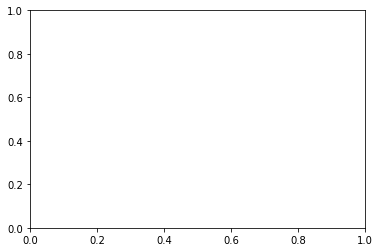

In [18]:
# Show graph
limit=100; start=40; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [90]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 40  has Coherence Value of 0.537
Num Topics = 46  has Coherence Value of 0.534
Num Topics = 52  has Coherence Value of 0.5244
Num Topics = 58  has Coherence Value of 0.5449
Num Topics = 64  has Coherence Value of 0.5535
Num Topics = 70  has Coherence Value of 0.5404
Num Topics = 76  has Coherence Value of 0.529
Num Topics = 82  has Coherence Value of 0.537
Num Topics = 88  has Coherence Value of 0.519
Num Topics = 94  has Coherence Value of 0.5259


In [106]:
optimal_model = model_list[4]
# optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(45,
  '0.054*"mpod" + 0.034*"pigment" + 0.028*"increase" + 0.026*"subject" + '
  '0.025*"lutein" + 0.022*"optical" + 0.020*"supplementation" + '
  '0.019*"velocity" + 0.017*"age" + 0.017*"carotenoid" + 0.017*"mg" + '
  '0.016*"density" + 0.015*"relate" + 0.015*"artery" + 0.015*"measure" + '
  '0.014*"significant" + 0.011*"significantly" + 0.011*"blood_flow" + '
  '0.010*"measurement" + 0.010*"density_mpod"'),
 (29,
  '0.041*"radiation" + 0.034*"dose" + 0.026*"ort" + 0.021*"radiotherapy" + '
  '0.021*"scene" + 0.020*"gy" + 0.017*"participant" + 0.016*"fraction" + '
  '0.014*"treatment" + 0.012*"control" + 0.012*"target" + 0.011*"range" + '
  '0.011*"deliver" + 0.011*"srt" + 0.010*"external_beam" + 0.010*"neovascular" '
  '+ 0.010*"beam" + 0.010*"mm" + 0.009*"therapy" + 0.009*"irradiation"'),
 (25,
  '0.264*"neovascular" + 0.142*"sup_sup" + 0.028*"membrane" + 0.023*"age" + '
  '0.017*"cox" + 0.017*"associate" + 0.013*"nonneovascular" + 0.012*"relate" + '
  '0.011*"sub_sub" + 0.009*"sub

In [132]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    pids = pd.Series(pmids)
    sent_topics_df = pd.concat([sent_topics_df, contents,pids], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','PMIDS']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,PMIDS
0,0,52.0,0.4685,"cnv, choroidal, eye, laser, occult, ttt, subfo...",We demonstrated the effectiveness of transpupi...,16922162
1,1,10.0,0.7123,"response, amplitude, function, mferg, retinal,...",The electrogenesis of the retinal macular regi...,19284097
2,2,9.0,0.6060,"drusen, area, eye, faf, image, atrophy, fundus...",To define the role of increased fundus autoflu...,25982972
3,3,53.0,0.3697,"cell, age, retinal, disease, relate, role, inf...",Retinal pigment epithelium (RPE)-derived membr...,20651235
4,4,54.0,0.1709,"ranibizumab, treatment, injection, letter, mon...",Although a reduced aflibercept (2.0 mg) inject...,26296050
5,5,0.0,0.4883,"surgery, hemorrhage, cataract_surgery, postope...",The place of surgery in DMLA amounts to the su...,14586233
6,6,24.0,0.4610,"mouse, expression, retinal, cell, induce, incr...",Age related macular degeneration (AMD) is the ...,28424619
7,7,61.0,0.4704,"early, late, age, association, associate, stud...",To assess the association between smoking and ...,17698756
8,8,37.0,0.8062,"cfh, risk, polymorphism, genotype, gene, allel...",To evaluate the association of CC-cytokine lig...,27316788
9,9,50.0,0.6291,"mg, safety, week, trial, sham, dose, efficacy,...",Safety data for anecortave acetate 15 mg suspe...,17240259


In [133]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text","PMIDS"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,PMIDS
0,0.0,0.8483,"surgery, hemorrhage, cataract_surgery, postope...",To report on the functional outcome of surgery...,18290952
1,1.0,0.6677,"year, study, treatment, age, datum, eye, visit...",To study the incidence of blindness and sight ...,27615601
2,2.0,0.7180,"thickness, eye, choroidal, retinal, subfoveal,...","Previously, we have shown that age-related mac...",25055214
3,3.0,0.6897,"type, lesion, neovascular, angiography, eye, c...",To describe the imaging of mixed neovascular a...,27022725
4,4.0,0.8606,"variant, genetic, gene, identify, risk, comple...",Macular degeneration is a common cause of blin...,24036949


In [134]:
sent_topics_sorteddf_mallet['Keywords'][0]

'surgery, hemorrhage, cataract_surgery, postoperative, translocation, subretinal, eye, retinal, preoperative, visual'

In [1]:
tempDf = df_dominant_topic
tempDf = tempDf.sort_values(by=['Dominant_Topic']).reset_index()
del tempDf['index']
tempDf

NameError: name 'df_dominant_topic' is not defined

In [186]:
# Number of Documents for Each Topic
topic_counts = tempDf['Dominant_Topic'].value_counts()
topic_counts

51.0    1122
37.0     298
54.0     298
15.0     260
53.0     250
6.0      246
5.0      215
61.0     209
11.0     193
4.0      184
56.0     167
24.0     167
17.0     162
0.0      146
22.0     134
9.0      133
3.0      130
57.0     125
12.0     117
2.0      116
43.0     115
21.0     110
35.0     101
40.0     101
41.0      96
47.0      93
36.0      93
50.0      92
16.0      90
42.0      89
        ... 
39.0      81
23.0      81
58.0      80
32.0      75
45.0      74
55.0      73
14.0      69
63.0      68
52.0      68
10.0      68
49.0      67
62.0      65
34.0      62
27.0      60
20.0      59
19.0      57
7.0       52
33.0      46
38.0      44
28.0      40
31.0      39
44.0      39
29.0      37
13.0      34
18.0      29
48.0      29
30.0      28
46.0      25
8.0       20
25.0       3
Name: Dominant_Topic, Length: 64, dtype: int64

In [162]:
topic_counts.sum()

7560

In [138]:
3/7560

0.0003968253968253968

In [163]:
topic_contribution = topic_counts/topic_counts.sum()

In [169]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.reset_index()
del topic_num_keywords['index']
topic_num_keywords = topic_num_keywords.sort_values(by=['Dominant_Topic']).reset_index()
del topic_num_keywords['index']
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"surgery, hemorrhage, cataract_surgery, postope..."
1,1.0,"year, study, treatment, age, datum, eye, visit..."
2,2.0,"thickness, eye, choroidal, retinal, subfoveal,..."
3,3.0,"type, lesion, neovascular, angiography, eye, c..."
4,4.0,"variant, genetic, gene, identify, risk, comple..."
5,5.0,"treatment, clinical, trial, therapy, review, p..."
6,6.0,"visual, eye, month, acuity, follow, line, year..."
7,7.0,"trial, treatment, placebo, participant, baseli..."
8,8.0,"study, age, result, report, show, relate, find..."
9,9.0,"drusen, area, eye, faf, image, atrophy, fundus..."


In [157]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Dominant_Topic,Dominant_Topic
0,52.0,"cnv, choroidal, eye, laser, occult, ttt, subfo...",146,0.019312
1,10.0,"response, amplitude, function, mferg, retinal,...",83,0.010979
2,9.0,"drusen, area, eye, faf, image, atrophy, fundus...",116,0.015344
3,53.0,"cell, age, retinal, disease, relate, role, inf...",130,0.017196
4,54.0,"ranibizumab, treatment, injection, letter, mon...",184,0.024339
5,0.0,"surgery, hemorrhage, cataract_surgery, postope...",215,0.028439
6,24.0,"mouse, expression, retinal, cell, induce, incr...",246,0.032540
7,61.0,"early, late, age, association, associate, stud...",52,0.006878
8,37.0,"cfh, risk, polymorphism, genotype, gene, allel...",20,0.002646
9,50.0,"mg, safety, week, trial, sham, dose, efficacy,...",133,0.017593


In [130]:
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,52.0,"cnv, choroidal, eye, laser, occult, ttt, subfo...",146.0,0.019312
1,10.0,"response, amplitude, function, mferg, retinal,...",83.0,0.010979
2,9.0,"drusen, area, eye, faf, image, atrophy, fundus...",116.0,0.015344
3,53.0,"cell, age, retinal, disease, relate, role, inf...",130.0,0.017196
4,54.0,"ranibizumab, treatment, injection, letter, mon...",184.0,0.024339
5,0.0,"surgery, hemorrhage, cataract_surgery, postope...",215.0,0.028439
6,24.0,"mouse, expression, retinal, cell, induce, incr...",246.0,0.032540
7,61.0,"early, late, age, association, associate, stud...",52.0,0.006878
8,37.0,"cfh, risk, polymorphism, genotype, gene, allel...",20.0,0.002646
9,50.0,"mg, safety, week, trial, sham, dose, efficacy,...",133.0,0.017593
